# DSLWP-B Doppler analysis

In this notebook we perform and analyse orbit determination of DSLWP-B using S-band Doppler measurments by Scott Tilley VE7TIL and GMAT.

In [1]:
%matplotlib inline

Set this to the path of your GMAT installation:

In [2]:
GMAT_PATH = '/home/daniel/GMAT/R2018a/'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess

# Larger figure size
fig_size = [10, 6]
plt.rcParams['figure.figsize'] = fig_size

Below we set the published frequency of the S-band beacon of DSLWP-B. There is an offset in the Doppler measurements by VE7TIL that we must correct. Probably, this Doppler is due to the beacon not been perfectly in frequency.

In [4]:
freq = 2275222e3
c = 299792458 # speed of light
f_shift = -3400 # Shift to apply to VE7TIL Doppler measurement

Utility functions to load reports from GMAT and write Doppler information in the format expected by GMAT.

In [5]:
def load_report(path):
    ncols = 14
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

def load_ve7til_doppler(path):
    ncols = 4
    leap_seconds = 37 # for UTC to TAI conversion
    data = np.fromfile(path, sep=' ')
    data = data.reshape((data.size // ncols, ncols))[:,:2]
    data[:,0] += leap_seconds/(24*3600) - 29999.5
    s = np.argsort(data[:,0])
    data = data[s,:]
    return data

def load_rangerate(path):
    with open(path) as f:
        return np.array([(l.split()[0], l.split()[7]) for l in f.readlines()[2:]], dtype='float')

def load_twoway(path):
    with open(path) as f:
        return np.array([(l.split()[0], l.split()[10]) for l in f.readlines()[2:]], dtype='float')

def write_doppler_gmd(data, path):
    doppler_interval = 10
    with open(path, 'w') as f:
        for j in range(data.shape[0]):
            line = '{} RangeRate 9012 VE7TIL DSLWP-B 1 {} {}\n'.format(data[j,0] + 0.5*doppler_interval/(24*3600), doppler_interval, -2*(data[j,1]-freq+f_shift)*1e-3*c/freq)
            f.write(line)

Position of each field in the GMAT report.

In [6]:
utc = 0
tai = 1
dslwp_x = 2
dslwp_v = 5
luna_x = 8
luna_v = 11

Load report file as computed by GMAT (note that the GMAT script `dslwp_doppler.script` must have been run before this in simulation mode to generate Doppler data). The report contains the position and velocity of DSLWP-B and the Moon in VE7TIL's frame of reference. This can be used to compute Doppler, disregarding the finite speed of light and the Doppler measurement interval.

In [7]:
report = load_report('VE7TIL.txt')
report_old = load_report('VE7TIL_old.txt')
report_gs = load_report('GS.txt')

Load Doppler data by VE7TIL, select some points to exclude because they do not give a good match, and write the Doppler information in GMAT's format.

In [8]:
doppler = load_ve7til_doppler('ve7til_doppler/dslwpb_lunarday1.dat')
ground_lock = ((doppler[:,0] > 28285.543) & (doppler[:,0] < 28286)) | ((doppler[:,0] > 28286.5417) & (doppler[:,0] < 28286.585)) | ((doppler[:,0] > 28282.4175) & (doppler[:,0] < 28283)) | ((doppler[:,0] > 28283.4165) & (doppler[:,0] < 28284)) | ((doppler[:,0] > 28284.44) & (doppler[:,0] < 28285)) \
    | ((doppler[:,0] > 28288.5) & (doppler[:,0] < 28288.53)) | ((doppler[:,0] > 28289.502) & (doppler[:,0] < 28289.5315))
exclude = ground_lock | ((doppler[:,0] > 28268.5) & (doppler[:,0] < 28269.2)) | ((doppler[:,0] > 28266.75) & (doppler[:,0] < 28267.5)) \
    | ((doppler[:,0] > 28272.5) & (doppler[:,0] < 28273.6)) | ((doppler[:,0] > 28281.37) & (doppler[:,0] < 28281.6)) \
    | ((doppler[:,0] > 28288.58) & (doppler[:,0] < 28289))
write_doppler_gmd(doppler[~exclude,:], '/tmp/VE7TIL.gmd')

Load simulated RangeRate information from GMAT (note that the GMAT script `dslwp_doppler.script` must have been run before this in estimation mode). Compute Doppler using the data from GMAT report.

In [9]:
gmat_doppler = load_rangerate(GMAT_PATH + 'output/DSLWP_Doppler.gmd')
#gs_gmat_doppler = load_twoway(GMAT_PATH + 'output/TwoWay_Doppler.gmd')

def rangerate(rep):
    return np.sum(rep[:,dslwp_v:dslwp_v+3] * rep[:,dslwp_x:dslwp_x+3], axis=1) / np.sqrt(np.sum(rep[:,dslwp_x:dslwp_x+3]**2, axis=1))

dslwp_rangerate = rangerate(report)
old_rangerate = rangerate(report_old)
gs_rangerate = rangerate(report_gs)

In [10]:
f_up = 2095.1e6
f_down = f_up * 240 / 221
two_way_doppler = -dslwp_rangerate * 1e3 / c * f_down - gs_rangerate * 1e3 / c * f_up

## Plot Doppler simulation from GMAT and VE7TIL's measurements.

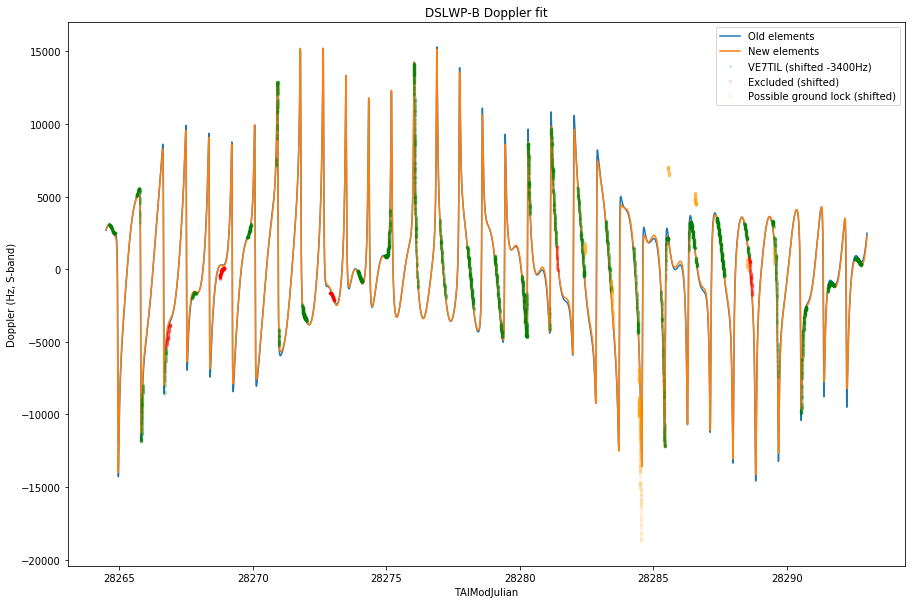

In [11]:
start = 0
end = 28293
select = (doppler[:,0] > start) & (doppler[:,0] < end)
report_select = (report[:,tai] > start) & (report[:,tai] < end)
report_old_select = (report_old[:,tai] > start) & (report_old[:,tai] < end)
plt.figure(figsize = [15,10], facecolor='w')
plt.plot(report_old[report_old_select, tai], -old_rangerate[report_old_select]*1e3*freq/c)
plt.plot(report[report_select, tai], -dslwp_rangerate[report_select]*1e3*freq/c)
#plt.plot(gmat_doppler[:,0], -0.5*gmat_doppler[:,1]*1e3*freq/c, '.', markersize=1, alpha=0.5)
plt.plot(doppler[~exclude & select,0], doppler[~exclude & select,1]-freq+f_shift,'.', alpha=0.1, markersize=5, color='green')
plt.plot(doppler[exclude & ~ground_lock & select,0], doppler[exclude & ~ground_lock & select,1]-freq+f_shift,'.', alpha=0.1, markersize=5, color='red')
plt.plot(doppler[ground_lock & select,0], doppler[ground_lock & select,1]-freq+f_shift,'.', alpha=0.1, markersize=5, color='orange')
plt.title('DSLWP-B Doppler fit')
plt.xlabel('TAIModJulian')
plt.ylabel('Doppler (Hz, S-band)')
plt.legend(['Old elements','New elements', 'VE7TIL (shifted {}Hz)'.format(f_shift), 'Excluded (shifted)', 'Possible ground lock (shifted)']);

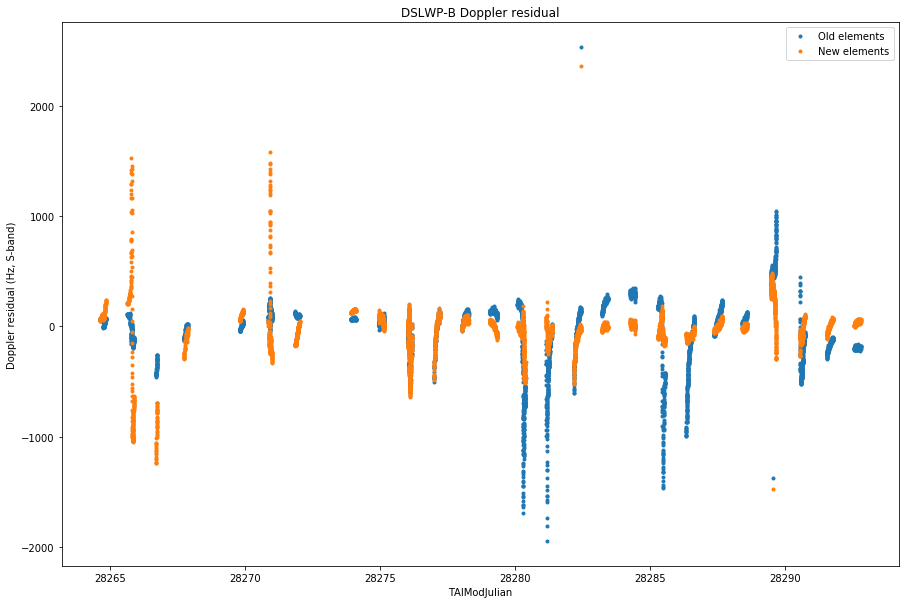

In [12]:
plt.figure(figsize = [15,10], facecolor='w')
t = doppler[~exclude,0]
plt.plot(t, doppler[~exclude,1]-freq+f_shift - np.interp(t, report_old[:, tai], -old_rangerate*1e3*freq/c) ,'.')
plt.plot(t, doppler[~exclude,1]-freq+f_shift - np.interp(t, report[:, tai], -dslwp_rangerate*1e3*freq/c) ,'.')
plt.title('DSLWP-B Doppler residual')
plt.xlabel('TAIModJulian')
plt.ylabel('Doppler residual (Hz, S-band)')
plt.legend(['Old elements', 'New elements']);

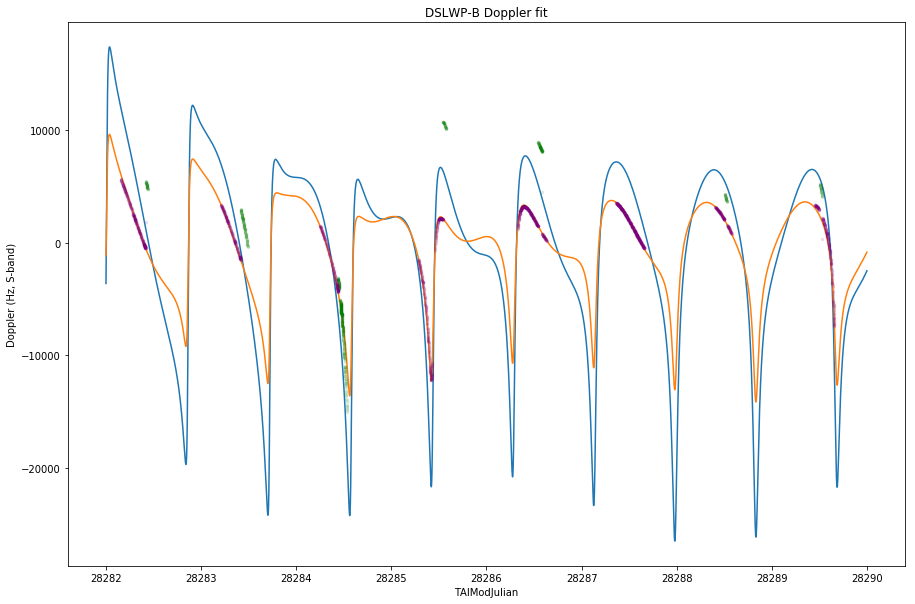

In [13]:
start = 28282
#start = 28284
end = 28290
#end = 28285
select = (doppler[:,0] > start) & (doppler[:,0] < end)
report_select = (report[:,tai] > start) & (report[:,tai] < end)
plt.figure(figsize = [15,10], facecolor='w')
plt.plot(report[report_select, tai], two_way_doppler[report_select])
plt.plot(report[report_select, tai], -dslwp_rangerate[report_select]*1e3*freq/c)
#plt.plot(gmat_doppler[:,0], -0.5*gmat_doppler[:,1]*1e3*freq/c, '.', markersize=1, alpha=0.5)
plt.plot(doppler[ground_lock & select,0], doppler[ground_lock & select,1]-f_down,'.', alpha=0.1, markersize=5, color='green')
plt.plot(doppler[~exclude & select,0], doppler[~exclude & select,1]-freq+f_shift,'.', alpha=0.1, markersize=5, color='purple')
#plt.plot(gs_gmat_doppler[:,0], -gs_gmat_doppler[:,1]-f_down,'.', color='blue', alpha=0.005, markersize=5)
plt.title('DSLWP-B Doppler fit')
plt.xlabel('TAIModJulian')
plt.ylabel('Doppler (Hz, S-band)');
#plt.legend(['GMAT (x and v)', 'GMAT (RangeRate simulation)', 'VE7TIL measurements (frequency shifted {}Hz)'.format(f_shift), 'Excluded VE7TIL measurements (frequency shifted {}Hz)'.format(f_shift)]);

In [14]:
def load_tracking_file(path):
    ncols = 7
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

In [15]:
def utc2taimodjulian(x):
    mjd_unixtimestamp_offset = 10587.5
    seconds_in_day = 3600 * 24
    leap_seconds = 37
    return (x + leap_seconds) / seconds_in_day + mjd_unixtimestamp_offset

In [16]:
ve7til_ecef = np.array([-2303967.2134504286, -3458727.86250663, 4822174.148309025])*1e-3

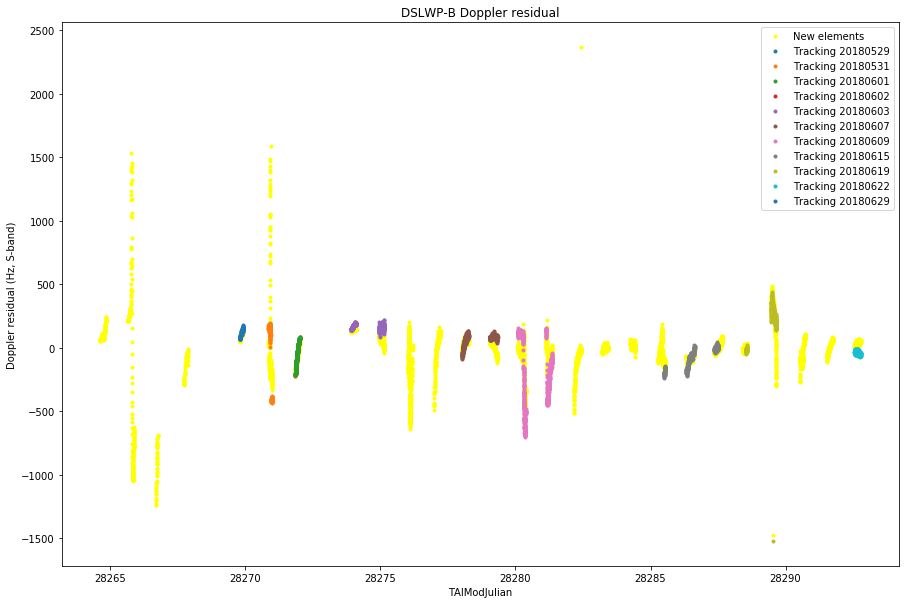

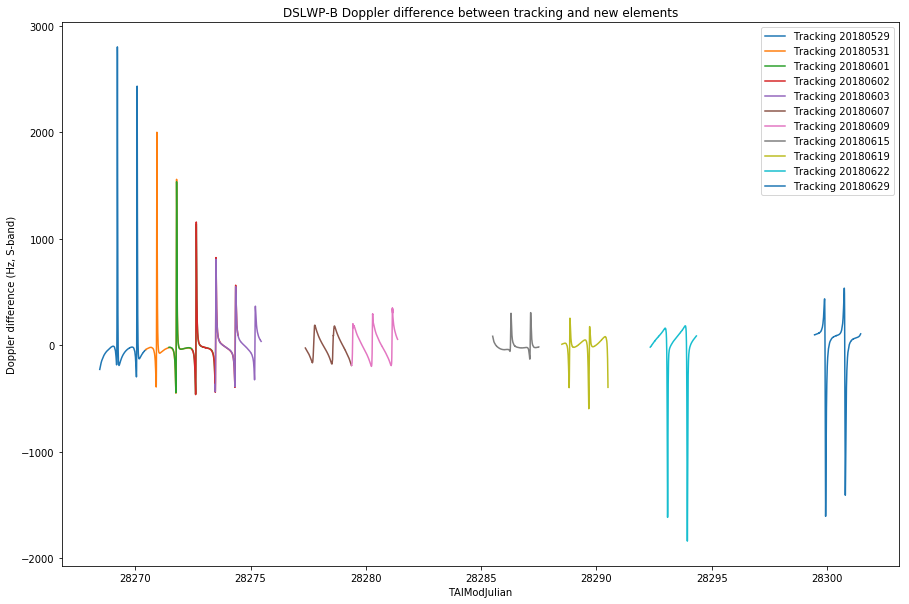

In [17]:
parts = ['20180529', '20180531', '20180601', '20180602', '20180603', '20180607', '20180609', '20180615', '20180619', '20180622', '20180629']

fig1 = plt.figure(figsize = [15,10], facecolor='w')
fig2 = plt.figure(figsize = [15,10], facecolor='w')
sub1 = fig1.add_subplot(111)
sub2 = fig2.add_subplot(111)

t = doppler[~exclude,0]
sub1.plot(t, doppler[~exclude,1]-freq+f_shift - np.interp(t, report[:, tai], -dslwp_rangerate*1e3*freq/c) ,'.', color='yellow')

for part in parts:
    tracking = load_tracking_file('tracking_files/program_tracking_dslwp-b_{}.txt'.format(part))
    tracking_range_rate = np.sum((tracking[:,1:4] - ve7til_ecef) * tracking[:,4:7], axis = 1) / np.sqrt(np.sum((tracking[:,1:4] - ve7til_ecef)**2, axis = 1)) * 1e3
    doppler_tracking = -tracking_range_rate * freq / c
    time = utc2taimodjulian(tracking[:,0])
    sub2.plot(time, doppler_tracking - np.interp(time, report[:,tai], -dslwp_rangerate*1e3*freq/c))
    time_sel = ~exclude & (doppler[:,0] > time[0]) & (doppler[:,0] < time[-1])
    sub1.plot(doppler[time_sel,0], doppler[time_sel,1]-freq+f_shift - np.interp(doppler[time_sel,0], time, doppler_tracking) ,'.')

sub1.set_title('DSLWP-B Doppler residual')
sub1.set_xlabel('TAIModJulian')
sub1.set_ylabel('Doppler residual (Hz, S-band)')
sub2.set_title('DSLWP-B Doppler difference between tracking and new elements')
sub2.set_xlabel('TAIModJulian')
sub2.set_ylabel('Doppler difference (Hz, S-band)')
sub1.legend(['New elements'] + ['Tracking {}'.format(part) for part in parts])
sub2.legend(['Tracking {}'.format(part) for part in parts]);